# MLP
MLP, K=5, droput, 150 epoch.

lncRNA. Baseline, nothing exluded.

Like MLP_260, which used GMM threshold on all cell lines except H1.hESC, but here use GMM on H1.hESC only.

In [1]:
from datetime import datetime
print(datetime.now())

2023-04-13 20:19:20.407058


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
#EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
EXCLUSIONS = [0,2,3,4,5,6,7,8,9,10,11,12,13,14]   # use only H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_265'

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-13 20:20:01.225202
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-13 20:20:01.628592
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 2982
Num RCI: 2982
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 2982 sequences.

Training # 1 1
2023-04-13 20:20:08.146190
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-13 20:20:08.369827
Discriminator is GMM
Means [-1.4457786698356236, 0.4066210490827031]
Variances [1.62452897 1.60011338]
Priors [0.43592685 0.56407315]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1434:945 60.28%
Valid 1:0 351:252 58.21%
FIT
2023-04-13 20:20:12.564772


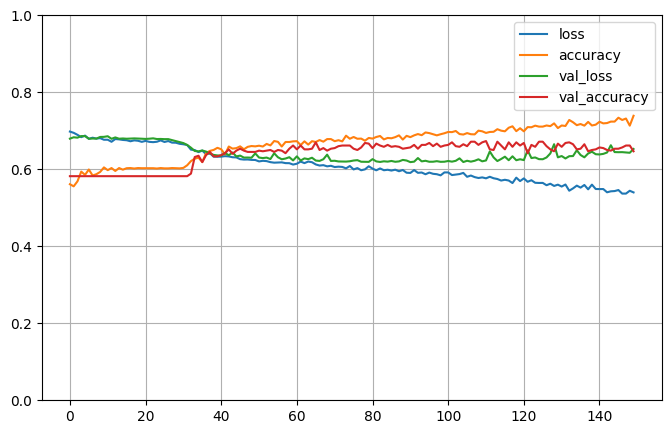


Testing # 1 1
2023-04-13 20:21:20.620281
2023-04-13 20:21:20.620674
PREDICT
2023-04-13 20:21:20.624842
Test 1:0 351:252 58.21%
Predict 1:0 460:143 76.29%
Test sizes (603, 1025) (603,)
Distrib of scores: 0.64837617 mean 0.21989876 std
Range of scores: 0.0085823815 to 0.9456154
Score threshold 0.5
Confusion matrix
 [[ 91 161]
 [ 52 299]]
Normalized matrix
 [[0.15091211 0.26699834]
 [0.08623549 0.49585406]]
Extreme scores correct, pos:neg 256 54
Extreme scores incorrect pos:neg 108 21


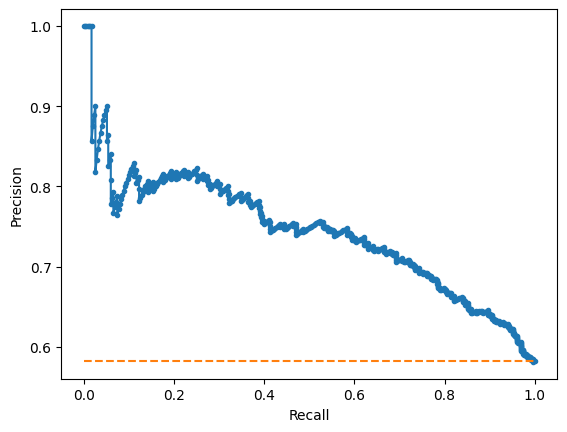

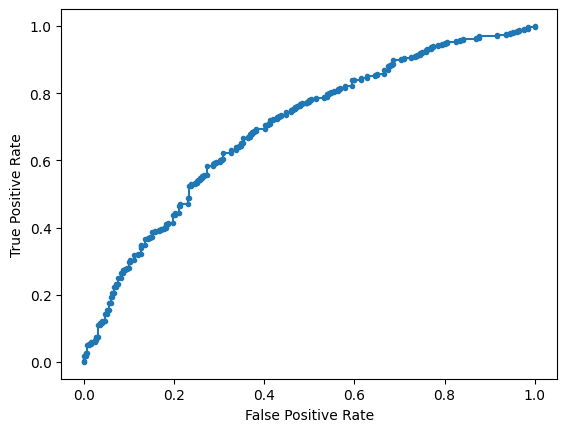

Accuracy: 64.68% Precision: 65.00% Recall: 85.19%
F1: 73.74% MCC: 0.2470
AUPRC: 74.37% AUROC: 69.68%
 accuracy [64.6766169154229]
 precision [65.0]
 recall [85.18518518518519]
 F1 [73.73612823674475]
 MCC [0.24695110545378912]
 AUPRC [74.36582483139634]
 AUROC [69.67733912178358]

Training # 1 2
2023-04-13 20:21:21.602558
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-13 20:21:21.811557
Discriminator is GMM
Means [-1.4152915682536868, 0.39321351620723277]
Variances [1.57420958 1.59437221]
Priors [0.44431919 0.55568081]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1391:998 58.23%
Valid 1:0 351:242 59.19%
FIT
2023-04-13 20:21:23.958318


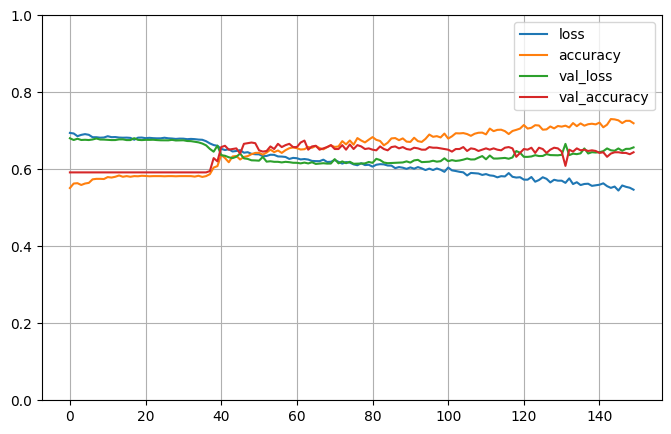


Testing # 1 2
2023-04-13 20:22:29.552261
2023-04-13 20:22:29.552323
PREDICT
2023-04-13 20:22:29.563427
Test 1:0 351:242 59.19%
Predict 1:0 442:151 74.54%
Test sizes (593, 1025) (593,)
Distrib of scores: 0.63893414 mean 0.21472341 std
Range of scores: 0.03704883 to 0.9877073
Score threshold 0.5
Confusion matrix
 [[ 91 151]
 [ 60 291]]
Normalized matrix
 [[0.153457   0.25463744]
 [0.10118044 0.49072513]]
Extreme scores correct, pos:neg 237 52
Extreme scores incorrect pos:neg 113 18


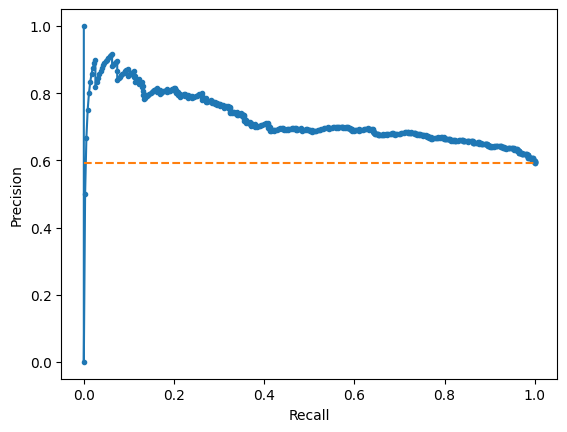

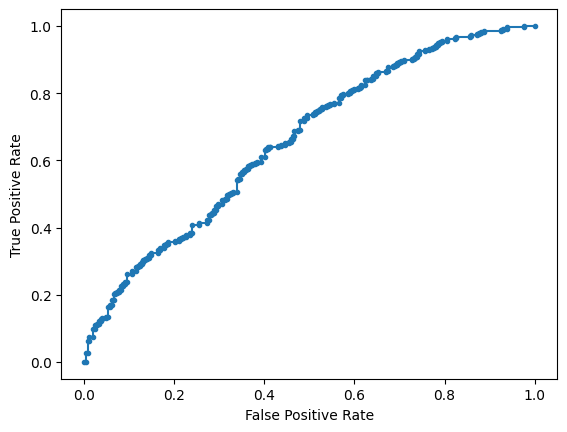

Accuracy: 64.42% Precision: 65.84% Recall: 82.91%
F1: 73.39% MCC: 0.2314
AUPRC: 72.02% AUROC: 65.86%
 accuracy [64.41821247892075]
 precision [65.83710407239819]
 recall [82.90598290598291]
 F1 [73.3921815889029]
 MCC [0.2313727621219862]
 AUPRC [72.0213537809861]
 AUROC [65.86023404205224]

Training # 1 3
2023-04-13 20:22:30.742015
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-13 20:22:31.009332
Discriminator is GMM
Means [-1.465289302586859, 0.40907207689802794]
Variances [1.51368463 1.51550776]
Priors [0.4286094 0.5713906]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1461:939 60.88%
Valid 1:0 331:251 56.87%
FIT
2023-04-13 20:22:34.008505


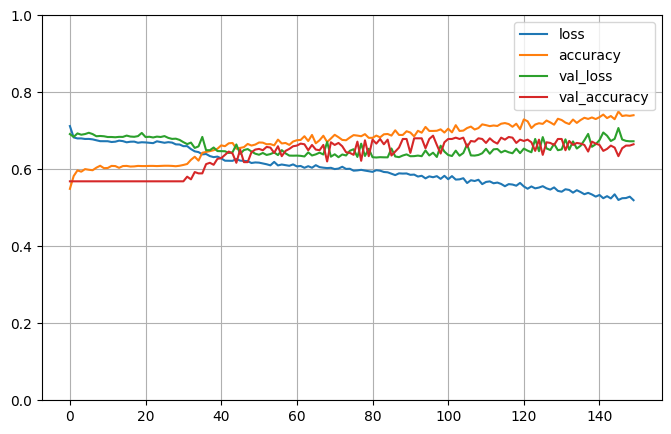


Testing # 1 3
2023-04-13 20:23:36.749557
2023-04-13 20:23:36.749598
PREDICT
2023-04-13 20:23:36.752946
Test 1:0 331:251 56.87%
Predict 1:0 394:188 67.70%
Test sizes (582, 1025) (582,)
Distrib of scores: 0.58721524 mean 0.23454277 std
Range of scores: 0.01697518 to 0.96328866
Score threshold 0.5
Confusion matrix
 [[122 129]
 [ 66 265]]
Normalized matrix
 [[0.20962199 0.22164948]
 [0.11340206 0.45532646]]
Extreme scores correct, pos:neg 188 78
Extreme scores incorrect pos:neg 91 34


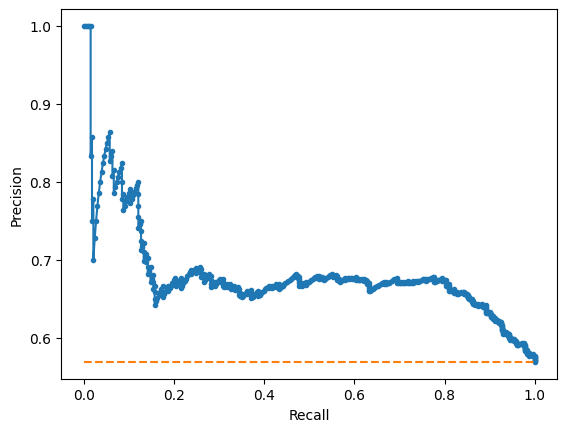

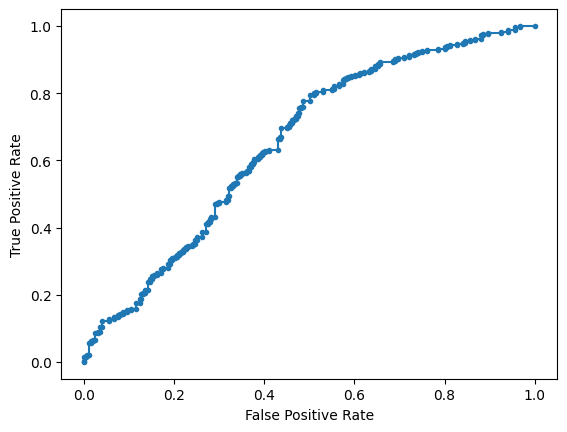

Accuracy: 66.49% Precision: 67.26% Recall: 80.06%
F1: 73.10% MCC: 0.3036
AUPRC: 68.11% AUROC: 65.20%
 accuracy [66.49484536082474]
 precision [67.25888324873097]
 recall [80.06042296072508]
 F1 [73.10344827586206]
 MCC [0.3035924231001387]
 AUPRC [68.10773464410302]
 AUROC [65.20142992982751]

Training # 1 4
2023-04-13 20:23:37.357642
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-13 20:23:37.546148
Discriminator is GMM
Means [0.41245694768976, -1.4630061329303885]
Variances [1.56688899 1.58956394]
Priors [0.5668711 0.4331289]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1433:950 60.13%
Valid 1:0 358:241 59.77%
FIT
2023-04-13 20:23:38.714288


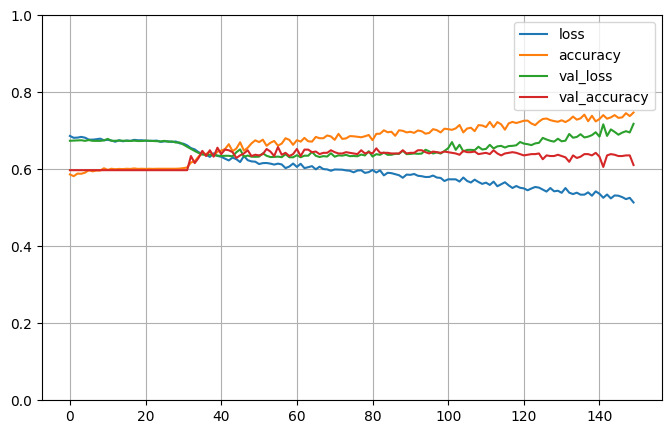


Testing # 1 4
2023-04-13 20:25:01.924769
2023-04-13 20:25:01.924819
PREDICT
2023-04-13 20:25:01.938835
Test 1:0 358:241 59.77%
Predict 1:0 363:236 60.60%
Test sizes (599, 1025) (599,)
Distrib of scores: 0.54339397 mean 0.25722206 std
Range of scores: 0.009410389 to 0.9885067
Score threshold 0.5
Confusion matrix
 [[122 119]
 [114 244]]
Normalized matrix
 [[0.20367279 0.19866444]
 [0.1903172  0.40734558]]
Extreme scores correct, pos:neg 173 96
Extreme scores incorrect pos:neg 73 70


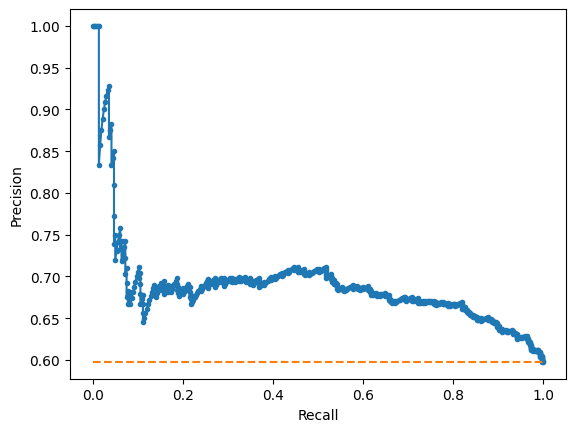

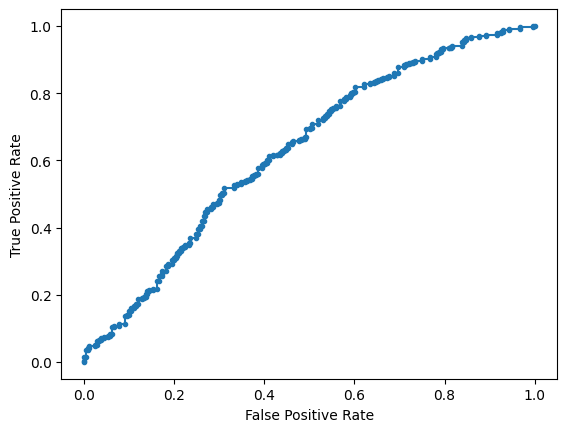

Accuracy: 61.10% Precision: 67.22% Recall: 68.16%
F1: 67.68% MCC: 0.1885
AUPRC: 68.94% AUROC: 62.98%
 accuracy [61.101836393989984]
 precision [67.21763085399449]
 recall [68.15642458100558]
 F1 [67.68377253814147]
 MCC [0.18845570071163584]
 AUPRC [68.9447955888663]
 AUROC [62.98245207352975]

Training # 1 5
2023-04-13 20:25:02.540256
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-13 20:25:02.758001
Discriminator is GMM
Means [0.36204973671170776, -1.488985980127083]
Variances [1.48007307 1.57031374]
Priors [0.56444287 0.43555713]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1418:959 59.66%
Valid 1:0 392:213 64.79%
FIT
2023-04-13 20:25:06.024673


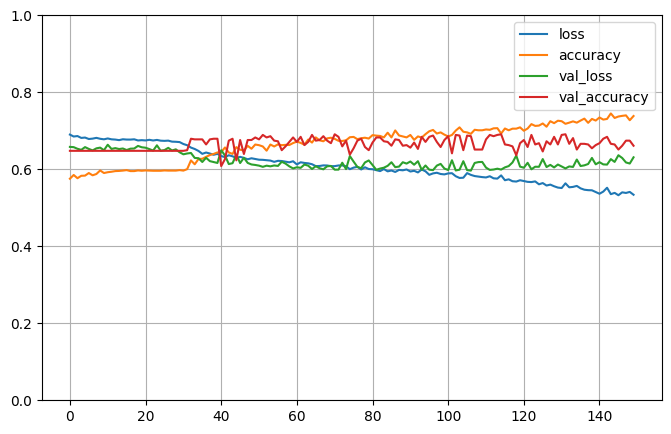


Testing # 1 5
2023-04-13 20:26:29.484966
2023-04-13 20:26:29.485019
PREDICT
2023-04-13 20:26:29.494696
Test 1:0 392:213 64.79%
Predict 1:0 403:202 66.61%
Test sizes (605, 1025) (605,)
Distrib of scores: 0.5900175 mean 0.23417915 std
Range of scores: 0.02570038 to 0.9481253
Score threshold 0.5
Confusion matrix
 [[105 108]
 [ 97 295]]
Normalized matrix
 [[0.17355372 0.1785124 ]
 [0.16033058 0.48760331]]
Extreme scores correct, pos:neg 222 70
Extreme scores incorrect pos:neg 73 52


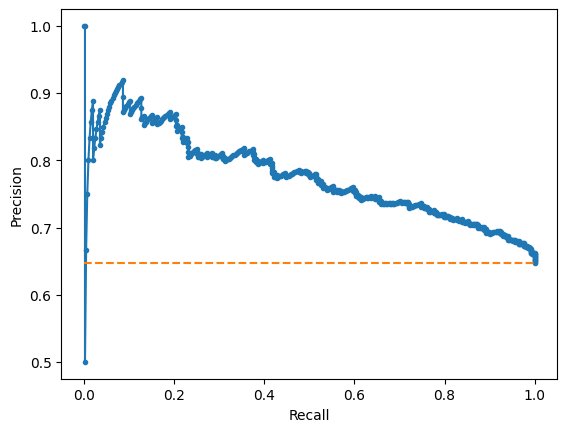

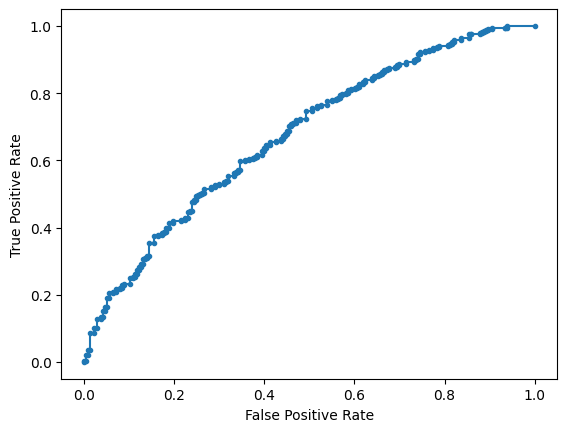

Accuracy: 66.12% Precision: 73.20% Recall: 75.26%
F1: 74.21% MCC: 0.2486
AUPRC: 77.58% AUROC: 67.39%
 accuracy [66.11570247933885]
 precision [73.20099255583126]
 recall [75.25510204081633]
 F1 [74.21383647798741]
 MCC [0.24864036371778384]
 AUPRC [77.58455479782332]
 AUROC [67.39484526204848]

Training # 2 1
2023-04-13 20:26:30.062799
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-13 20:26:30.256885
Discriminator is GMM
Means [-1.464353283811784, 0.4251310296777448]
Variances [1.44551628 1.48626079]
Priors [0.4279693 0.5720307]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1437:941 60.43%
Valid 1:0 347:257 57.45%
FIT
2023-04-13 20:26:31.421837


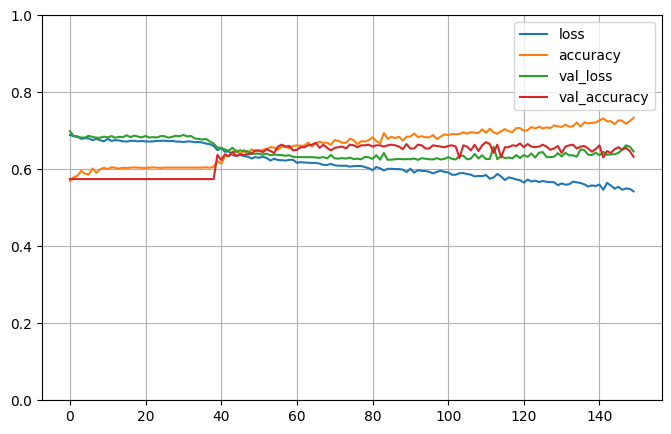


Testing # 2 1
2023-04-13 20:27:54.644085
2023-04-13 20:27:54.644135
PREDICT
2023-04-13 20:27:54.657633
Test 1:0 347:257 57.45%
Predict 1:0 399:205 66.06%
Test sizes (604, 1025) (604,)
Distrib of scores: 0.57185525 mean 0.22746903 std
Range of scores: 0.00838104 to 0.940904
Score threshold 0.5
Confusion matrix
 [[120 137]
 [ 85 262]]
Normalized matrix
 [[0.1986755  0.22682119]
 [0.14072848 0.43377483]]
Extreme scores correct, pos:neg 199 85
Extreme scores incorrect pos:neg 90 36


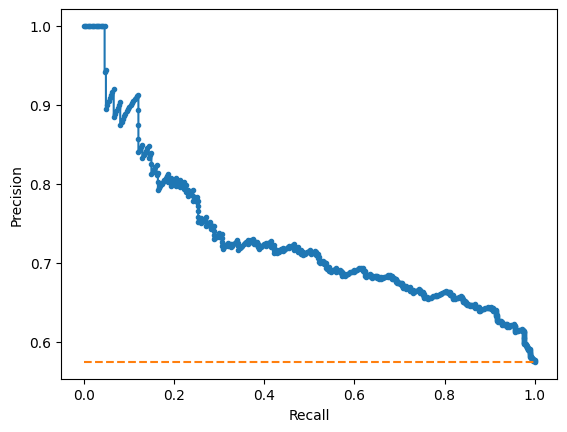

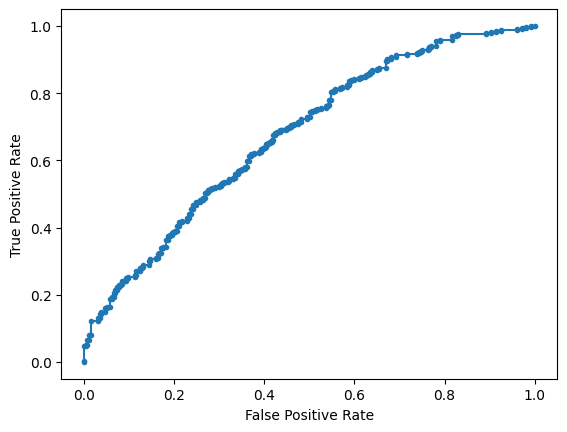

Accuracy: 63.25% Precision: 65.66% Recall: 75.50%
F1: 70.24% MCC: 0.2318
AUPRC: 73.04% AUROC: 67.59%
 accuracy [63.24503311258278]
 precision [65.6641604010025]
 recall [75.50432276657061]
 F1 [70.24128686327077]
 MCC [0.2317719254309511]
 AUPRC [73.03611558629504]
 AUROC [67.59326747328407]

Training # 2 2
2023-04-13 20:27:55.264669
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-13 20:27:55.461221
Discriminator is GMM
Means [0.3724246455927556, -1.5122954038128853]
Variances [1.54849273 1.52891538]
Priors [0.57970328 0.42029672]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1478:914 61.79%
Valid 1:0 364:226 61.69%
FIT
2023-04-13 20:27:56.615193


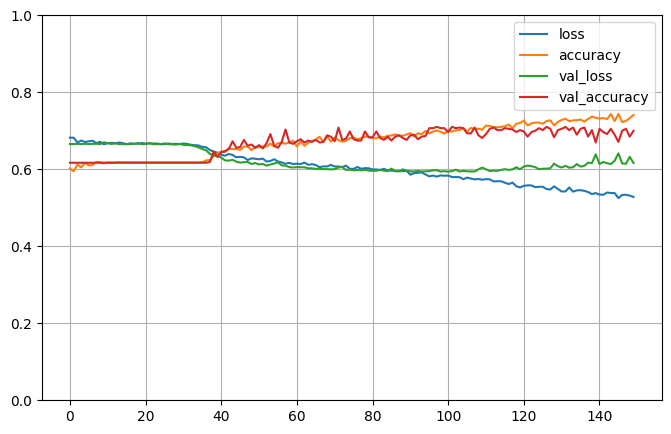


Testing # 2 2
2023-04-13 20:29:19.853429
2023-04-13 20:29:19.853477
PREDICT
2023-04-13 20:29:19.857853
Test 1:0 364:226 61.69%
Predict 1:0 447:143 75.76%
Test sizes (590, 1025) (590,)
Distrib of scores: 0.64101833 mean 0.22148691 std
Range of scores: 0.03148856 to 0.96817195
Score threshold 0.5
Confusion matrix
 [[ 96 130]
 [ 47 317]]
Normalized matrix
 [[0.16271186 0.22033898]
 [0.07966102 0.53728814]]
Extreme scores correct, pos:neg 254 53
Extreme scores incorrect pos:neg 85 25


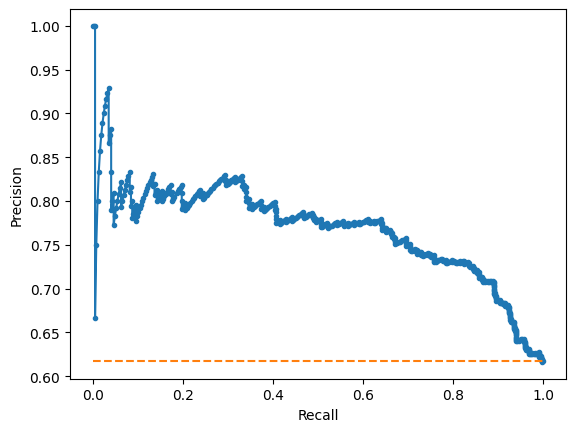

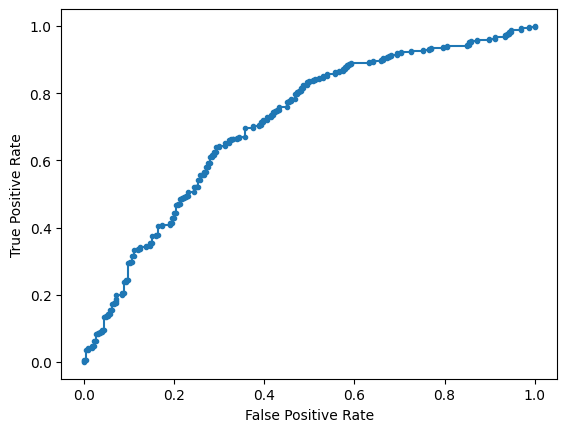

Accuracy: 70.00% Precision: 70.92% Recall: 87.09%
F1: 78.18% MCC: 0.3354
AUPRC: 76.83% AUROC: 71.02%
 accuracy [70.0]
 precision [70.917225950783]
 recall [87.08791208791209]
 F1 [78.1750924784217]
 MCC [0.33540736319843173]
 AUPRC [76.82878294349194]
 AUROC [71.0164835164835]

Training # 2 3
2023-04-13 20:29:20.465614
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-13 20:29:20.692432
Discriminator is GMM
Means [0.40555670122899445, -1.4433631537163252]
Variances [1.5181444  1.62442123]
Priors [0.55511268 0.44488732]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1390:994 58.31%
Valid 1:0 364:234 60.87%
FIT
2023-04-13 20:29:21.876559


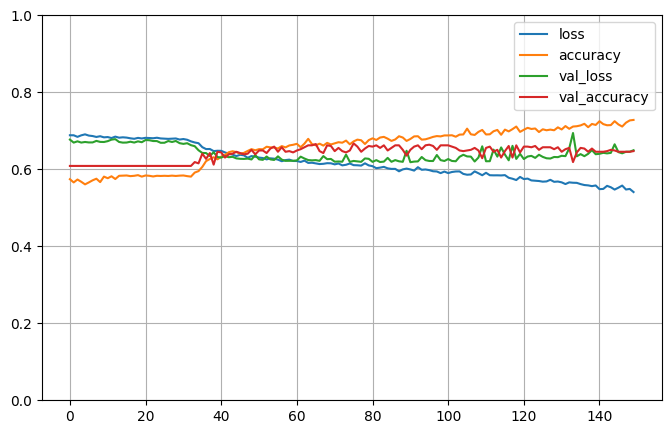


Testing # 2 3
2023-04-13 20:30:45.603534
2023-04-13 20:30:45.603583
PREDICT
2023-04-13 20:30:45.615355
Test 1:0 364:234 60.87%
Predict 1:0 407:191 68.06%
Test sizes (598, 1025) (598,)
Distrib of scores: 0.5865672 mean 0.22966193 std
Range of scores: 0.015683137 to 0.963474
Score threshold 0.5
Confusion matrix
 [[107 127]
 [ 84 280]]
Normalized matrix
 [[0.17892977 0.21237458]
 [0.14046823 0.46822742]]
Extreme scores correct, pos:neg 212 70
Extreme scores incorrect pos:neg 81 44


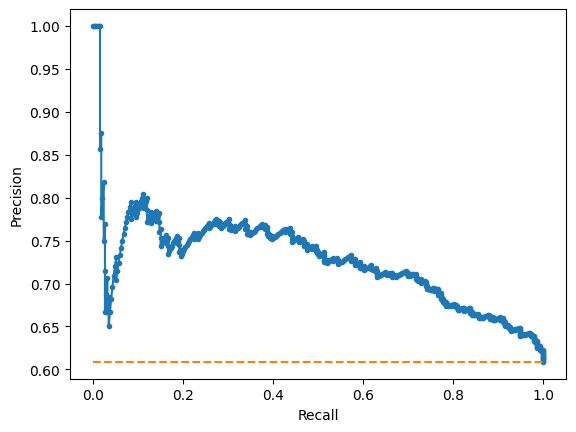

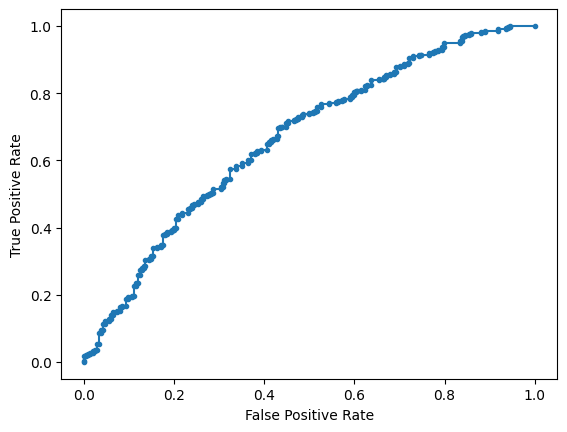

Accuracy: 64.72% Precision: 68.80% Recall: 76.92%
F1: 72.63% MCC: 0.2371
AUPRC: 72.73% AUROC: 66.45%
 accuracy [64.71571906354515]
 precision [68.7960687960688]
 recall [76.92307692307693]
 F1 [72.63294422827498]
 MCC [0.23708536399793906]
 AUPRC [72.72608319386177]
 AUROC [66.44712125481355]

Training # 2 4
2023-04-13 20:30:46.231190
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-13 20:30:46.436455
Discriminator is GMM
Means [0.39872987653846226, -1.4178979705195447]
Variances [1.60495034 1.6257418 ]
Priors [0.55493011 0.44506989]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1403:998 58.43%
Valid 1:0 345:236 59.38%
FIT
2023-04-13 20:30:50.486224


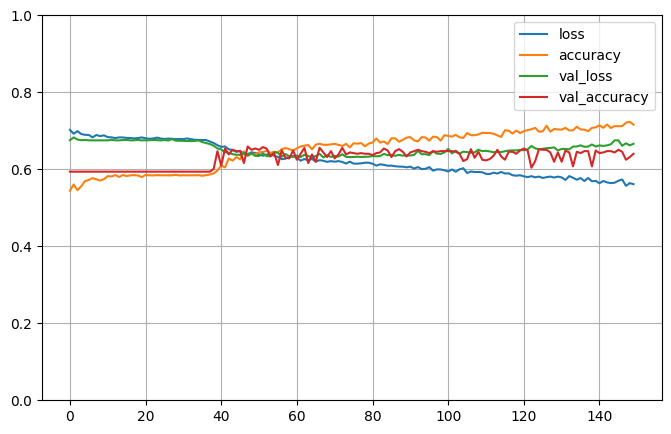


Testing # 2 4
2023-04-13 20:32:14.052766
2023-04-13 20:32:14.052841
PREDICT
2023-04-13 20:32:14.057679
Test 1:0 345:236 59.38%
Predict 1:0 442:139 76.08%
Test sizes (581, 1025) (581,)
Distrib of scores: 0.6399584 mean 0.20401888 std
Range of scores: 0.054021604 to 0.96813065
Score threshold 0.5
Confusion matrix
 [[ 83 153]
 [ 56 289]]
Normalized matrix
 [[0.14285714 0.26333907]
 [0.09638554 0.49741824]]
Extreme scores correct, pos:neg 218 49
Extreme scores incorrect pos:neg 116 20


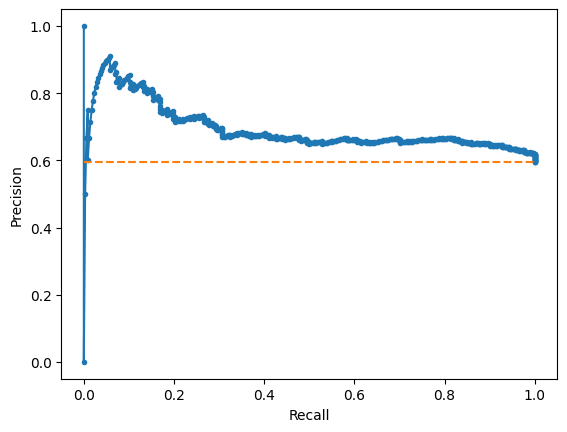

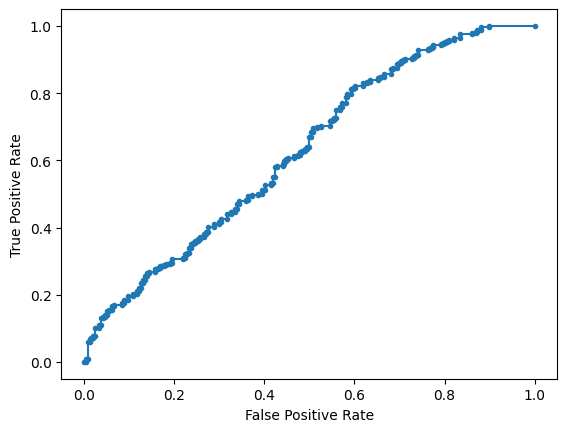

Accuracy: 64.03% Precision: 65.38% Recall: 83.77%
F1: 73.44% MCC: 0.2180
AUPRC: 69.23% AUROC: 62.72%
 accuracy [64.02753872633392]
 precision [65.38461538461539]
 recall [83.76811594202898]
 F1 [73.44345616264295]
 MCC [0.21800784633871595]
 AUPRC [69.23146109972498]
 AUROC [62.72414640137558]

Training # 2 5
2023-04-13 20:32:14.691737
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-13 20:32:14.910303
Discriminator is GMM
Means [0.3530356654919976, -1.489292428277836]
Variances [1.60652301 1.61718002]
Priors [0.58078045 0.41921955]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1475:898 62.16%
Valid 1:0 385:224 63.22%
FIT
2023-04-13 20:32:16.105766


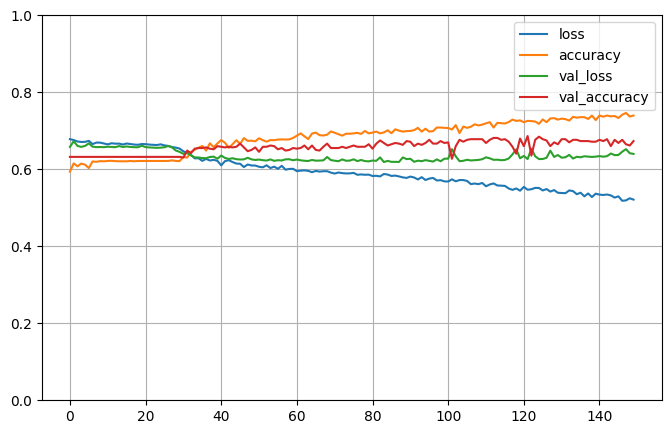


Testing # 2 5
2023-04-13 20:33:39.367905
2023-04-13 20:33:39.367959
PREDICT
2023-04-13 20:33:39.372017
Test 1:0 385:224 63.22%
Predict 1:0 448:161 73.56%
Test sizes (609, 1025) (609,)
Distrib of scores: 0.62935865 mean 0.22698735 std
Range of scores: 0.030146541 to 0.97181773
Score threshold 0.5
Confusion matrix
 [[ 93 131]
 [ 68 317]]
Normalized matrix
 [[0.15270936 0.21510673]
 [0.11165846 0.52052545]]
Extreme scores correct, pos:neg 256 59
Extreme scores incorrect pos:neg 90 38


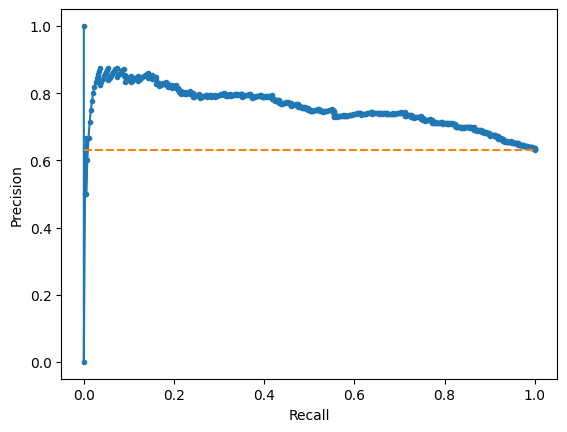

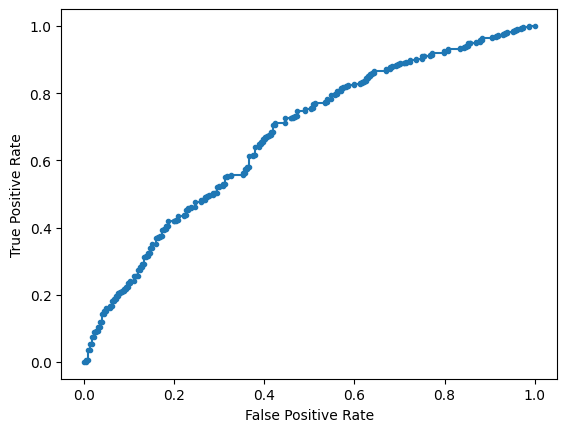

Accuracy: 67.32% Precision: 70.76% Recall: 82.34%
F1: 76.11% MCC: 0.2609
AUPRC: 75.62% AUROC: 67.20%
 accuracy [67.32348111658456]
 precision [70.75892857142857]
 recall [82.33766233766234]
 F1 [76.11044417767107]
 MCC [0.26085027994876026]
 AUPRC [75.61916694568154]
 AUROC [67.2008348794063]
2023-04-13 20:33:39.963371


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                cvdo.save_model(filename)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 65.21% std 2.43
 precision mean 68.00% std 2.81
 recall mean 79.72% std 5.74
 F1 mean 73.27% std 2.87
 MCC mean 0.2502 std 0.0421
 AUPRC mean 72.85% std 3.33
 AUROC mean 66.61% std 2.62
 accuracy [[64.6766169154229], [64.41821247892075], [66.49484536082474], [61.101836393989984], [66.11570247933885], [63.24503311258278], [70.0], [64.71571906354515], [64.02753872633392], [67.32348111658456]]
 precision [[65.0], [65.83710407239819], [67.25888324873097], [67.21763085399449], [73.20099255583126], [65.6641604010025], [70.917225950783], [68.7960687960688], [65.38461538461539], [70.75892857142857]]
 recall [[85.18518518518519], [82.90598290598291], [80.06042296072508], [68.15642458100558], [75.25510204081633], [75.50432276657061], [87.08791208791209], [76.92307692307693], [83.76811594202898], [82.33766233766234]]
 F1 [[73.73612823674475], [73.3921815889029], [73.10344827586206], [67.68377253814147], [74.21383647798741], [70.24128686327077], [78.1750924784217], [72.6329442282749